## Train and Prediction on all data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage

In [3]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [4]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [5]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [6]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [7]:
RETRAIN = True
RESIZE_IMAGES = True

In [8]:
img_size=256

In [11]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [12]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [13]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [14]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [18]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [19]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [15]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [16]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=data_dir/f'train/{img_size}', df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(data_dir/'test/{img_size}'))

In [17]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

FileNotFoundError: [Errno 2] No such file or directory: 'data/train/256/7a204ec4.tif'

In [ ]:
dir(data)

In [ ]:
data.label_list

In [ ]:
data.loss_func

`show_batch` still works, and show us the different labels separated by `;`.

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [ ]:
arch = models.resnet50

In [ ]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True)

In [ ]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### (Re)train model

In [ ]:
if RETRAIN:
    learn.lr_find()

In [ ]:
if RETRAIN:
    learn.recorder.plot()

Then we can fit the head of our network.

In [ ]:
if RETRAIN:
    lr = 1e-1

In [ ]:
if RETRAIN:
    learn.fit_one_cycle(5, slice(lr))

In [ ]:
if RETRAIN:
    learn.save('stage-1-rn50')
    #saves in parent of models directory
    learn.export()

#### Load model

In [ ]:
if RETRAIN:
    learn.load('stage-1-rn50')

### Re-train

In [56]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


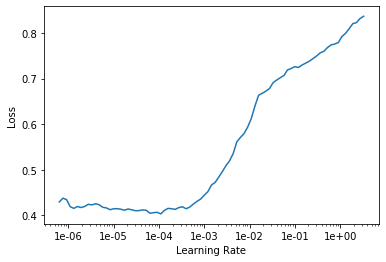

In [57]:
learn.lr_find()
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.450725,0.815048,0.264908,00:20
1,0.471160,0.515863,0.181193,00:20
2,0.460313,0.463840,0.167431,00:20
3,0.437917,0.448464,0.170872,00:20
4,0.402474,0.441463,0.168578,00:20


In [59]:
learn.save('stage-2-rn50')

In [20]:
learn.load('stage-2-rn50')

FileNotFoundError: [Errno 2] No such file or directory: 'data/colombia_borde_rural/cropped/train/256/models/stage-2-rn50.pth'

In [60]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [61]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


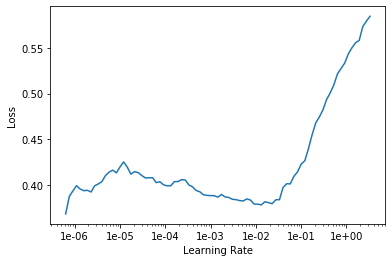

In [62]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.087761,0.085013,0.958006,0.926066
2,0.087641,0.083732,0.958260,0.927459
3,0.084250,0.082856,0.958485,0.928200
4,0.082347,0.081470,0.960091,0.929166
5,0.078463,0.080984,0.959249,0.930089


In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.082938,0.083548,0.957846,0.927756
2,0.086312,0.084802,0.958718,0.925416
3,0.084824,0.082339,0.959975,0.930054
4,0.078784,0.081425,0.959983,0.929634
5,0.074530,0.080791,0.960426,0.931257


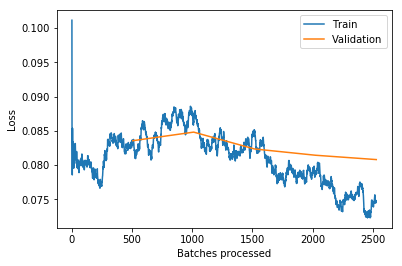

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

### inference

In [ ]:
test=ImageList.from_folder(path/f'test/{img_size}')

In [ ]:
learn = load_learner(path/f'train/{img_size}', test=test)

In [ ]:
learn.data.loss_func

In [ ]:
type(learn.data)

In [ ]:
type(learn.dl(DatasetType.Test))

Get number of items in the Valid dataset (in DeviceDataLoader)

In [ ]:
len(learn.dl(DatasetType.Test).dl)

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [ ]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
labels = np.argmax(preds, 1)

In [ ]:
len(preds)

In [ ]:
preds[0].tolist()

In [ ]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [ ]:
len(labels)

In [ ]:
learn.data.classes

In [ ]:
data.classes

In [ ]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [ ]:
test_predictions[0]

In [ ]:
type(learn.data.test_ds)

In [ ]:
 learn.data.test_ds.x.items

In [ ]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [ ]:
preds_list[0]

In [ ]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [ ]:
cols

In [ ]:
df.head()

In [ ]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [ ]:
pred_df.insert(loc=0, column='id', value=ids)

In [ ]:
pred_df.columns = cols

In [ ]:
pred_df.head()

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>
